In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
from keras import layers, optimizers
from keras.preprocessing.image import ImageDataGenerator

from sklearn.decomposition import PCA
from sklearn import tree

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
fig_shape = None #Valore che ricaviamo inseguito 
batch_size = 512

In [4]:
labels = os.listdir('fruits-360/Training')
labels.sort()
print('Il dataset contiene %i classi di frutta: ' %(len(labels)))
print(labels)

Il dataset contiene 131 classi di frutta: 
['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 

### Load and split the dataset into Training (80%) and Validation (20%) dataset

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split = 0.2,
)

train = train_datagen.flow_from_directory(
    'fruits-360/Training',
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,
    subset = 'training',
    seed = 42,
)

validation = train_datagen.flow_from_directory(
    'fruits-360/Training',
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,
    subset = 'validation',
    seed = 42,
)

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.


### Load the Test dataset

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
)

test = train_datagen.flow_from_directory(
    'fruits-360/Test',
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
)

Found 22688 images belonging to 131 classes.


### Some fruits exaple

In [5]:
train

# Convolutional Neural Network

In [24]:
model = Sequential()
model.add(layers.Input(shape = (100,100,3)))

model.add(layers.Conv2D(8 , 3, activation = 'swish'))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(8 , 3, activation = 'swish'))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(8 , 3, activation = 'swish'))
model.add(layers.MaxPooling2D(2))

model.add(layers.Flatten())
model.add(layers.Dense(131, activation = "softmax"))

model.compile(optimizer = optimizers.RMSprop(learning_rate=0.0001), loss = tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 98, 98, 8)         224       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 49, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 47, 8)         584       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 8)         584       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 8)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)              

In [25]:
history = model.fit(
    train,
    batch_size = batch_size,
    epochs = 20,
    validation_data = validation,
    steps_per_epoch = len(train),
    validation_steps = len(validation)
)

Epoch 1/20
106/106 [==============================] - 24s 224ms/step - loss: 4.7945 - accuracy: 0.0157 - val_loss: 4.6718 - val_accuracy: 0.0168
Epoch 2/20
106/106 [==============================] - 24s 223ms/step - loss: 4.3098 - accuracy: 0.0782 - val_loss: 3.9009 - val_accuracy: 0.1115
Epoch 3/20
106/106 [==============================] - 24s 223ms/step - loss: 3.2464 - accuracy: 0.2410 - val_loss: 3.0322 - val_accuracy: 0.3115
Epoch 4/20
106/106 [==============================] - 23s 221ms/step - loss: 2.4060 - accuracy: 0.4137 - val_loss: 2.5109 - val_accuracy: 0.4085
Epoch 5/20
106/106 [==============================] - 24s 223ms/step - loss: 1.8948 - accuracy: 0.5313 - val_loss: 2.1022 - val_accuracy: 0.4862
Epoch 6/20
106/106 [==============================] - 24s 223ms/step - loss: 1.5136 - accuracy: 0.6149 - val_loss: 1.7840 - val_accuracy: 0.5607
Epoch 7/20
106/106 [==============================] - 24s 222ms/step - loss: 1.2159 - accuracy: 0.6892 - val_loss: 1.5714 - val_ac

### Visualize the loss function and the accuracy through the training

In [26]:
print('Informations stored in hystory:')
for key in history.history.keys():
    print(key)

Informations stored in hystory:
loss
accuracy
val_loss
val_accuracy


Text(0.5, 1.0, 'Loss')

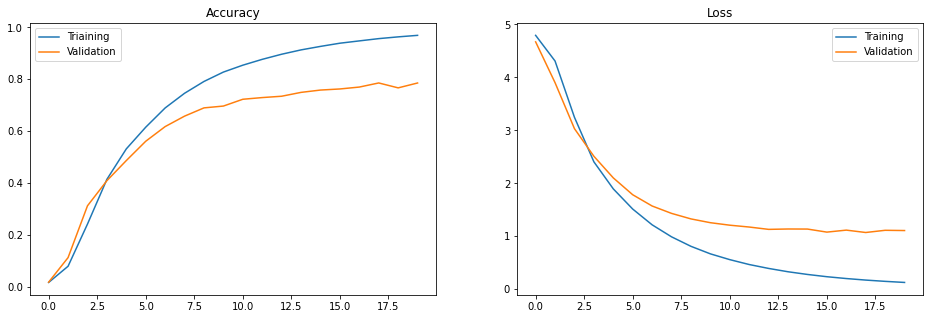

In [27]:
_ , ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(history.history['accuracy'], label = 'Triaining')
ax[0].plot(history.history['val_accuracy'], label = 'Validation')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['loss'], label = 'Training')
ax[1].plot(history.history['val_loss'], label = 'Validation')
ax[1].legend()
ax[1].set_title('Loss')

### Evaluate the model on the Test Dataset

In [28]:
score = model.evaluate(test, batch_size = batch_size, steps = len(test))

45/45 [==============================] - 8s 172ms/step - loss: 1.3216 - accuracy: 0.7473


In [29]:
print('**********************************************')
print('* Acurracy of the model = %s *' %(score[1]))
print('**********************************************')

**********************************************
* Acurracy of the model = 0.7472673058509827 *
**********************************************


# PCA and Decision Tree

In [5]:
number_of_images = 10000

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
)

train = train_datagen.flow_from_directory(
    'fruits-360/Training',
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=number_of_images,
    class_mode='categorical',
    shuffle = True,
    seed = 42,
)

Found 67692 images belonging to 131 classes.


In [6]:
x , y = next(train) 

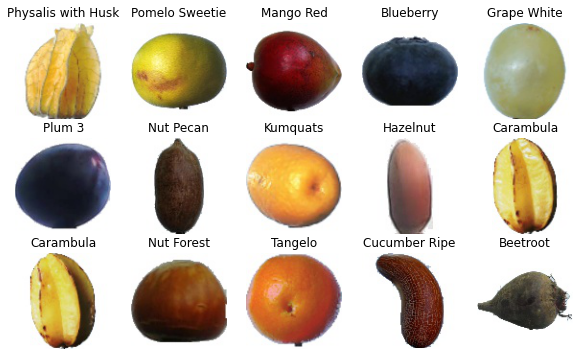

In [7]:
_ , axs = plt.subplots(3,5, figsize = (10,6))
for i, ax in enumerate(axs.ravel()):
    index = np.random.randint(0, x.shape[0])
    ax.imshow(x[index])
    ax.set_title(labels[np.argmax(y[index])])
    ax.axis('off')

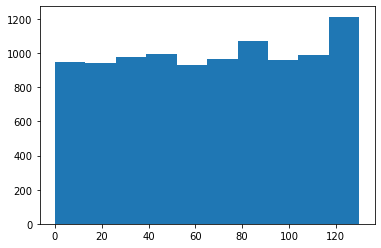

In [8]:
plt.hist(np.argmax(y, axis = 1))
plt.show()

### Dimension reduction using PCA

In [10]:
#x_reshaped = x.reshape((x.shape[0],3*100*100)).copy()
#print(x_reshaped.shape)
#pca = PCA(n_components=0.95)
#x_reduced = pca.fit_transform(x_reshaped)
#print(x_reduced.shape)

(10000, 225)


In [13]:
x = np.load('pca_095.npy')
print(x.shape)

(10000, 225)


### Decision Tree